In [1]:
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import codecs
from konlpy.tag import Twitter
from gensim.models import word2vec
from konlpy.utils import pprint
from sklearn.manifold import TSNE

import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from tensorflow.keras.datasets import imdb
from konlpy.tag import Twitter
from konlpy.tag import Okt
from konlpy.tag import Kkma 
from konlpy.tag import Twitter
from pprint import pprint
import nltk
from nltk.classify.scikitlearn import SklearnClassifier
from wordcloud import WordCloud, STOPWORDS
from gensim import corpora, models
import numpy  as np
from PIL import Image
from wordcloud import ImageColorGenerator
import glob
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
%matplotlib inline

# 2. 네이버 리뷰 분석

## 2.1. data
- 데이터는 문장들의 집합으로 구성
- 리스트 안에 리스트 형태로 구성

### 차원 주의!!!
> 문장은 의미가 없음
- 입력만 문장단위로 들어갔을 뿐
- 단어로만 분석이 들어감(주변단어, 중심단어로 거리 파악)

In [2]:
def read_data(filename):
    with open(filename, encoding = 'utf-8', mode = 'r') as f:
        data = [line.split('\t') for line in f.read() .splitlines()]
        data = data[1:] # header 제외
    return data

rating_train = read_data('ratings_train.txt')
        

In [3]:
rating_train[1]

['3819312', '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나', '1']

In [42]:
len(rating_train) # 150000개 데이터 

150000

### 형태소 분석기로 단어 선별하기

In [4]:
okt = Okt()

In [5]:
# 형태소 분석해서 '단어/형태소 ' 형태로 만들기
def tokens(doc):
    return ['/'.join(t) for t in okt.pos(doc, norm = True, stem = True)]

In [6]:
tokens(rating_train[1][1])

['흠/Noun',
 '.../Punctuation',
 '포스터/Noun',
 '보고/Noun',
 '초딩/Noun',
 '영화/Noun',
 '줄/Noun',
 '..../Punctuation',
 '오버/Noun',
 '연기/Noun',
 '조차/Josa',
 '가볍다/Adjective',
 '않다/Verb']

In [7]:
docs = []
for row in rating_train:
    docs.append(row[1])
docs[:10]    

['아 더빙.. 진짜 짜증나네요 목소리',
 '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나',
 '너무재밓었다그래서보는것을추천한다',
 '교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정',
 '사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다',
 '막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.',
 '원작의 긴장감을 제대로 살려내지못했다.',
 '별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네',
 '액션이 없는데도 재미 있는 몇안되는 영화',
 '왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?']

In [8]:
len(docs)  # 15000차원

150000

data = [tokens(d) for d in docs]

In [44]:
data[0]

['아/Exclamation',
 '더빙/Noun',
 '../Punctuation',
 '진짜/Noun',
 '짜증나다/Adjective',
 '목소리/Noun']

## 2.2. model

In [ ]:
w2v_model = Word2Vec(data,
                    size = 100, # 100차원
                    window = 3,
                    min_count = 3)

In [ ]:
w2v_model.save('namver.model')

In [45]:
# 단어벡터를 구한다.
word_vectors = w2v_model.wv

## 2.3 총 단어 확인

In [46]:
len(word_vectors.vocab.keys())

21093

## 2.3. 유사도

In [ ]:
# 남자 + 여배우 = 배우 = 여자
# 남자 - 배우 = 여자 - 여배우
# u' : 유니코드 인코딩 방식임.->안써도 됨..(editor가 unicode이므로 상관없음.)
w2v_model.wv.most_similar(positive = tokens(u'남자 여배우'),
                          negative = tokens(u'배우'),
                          topn = 5)

In [ ]:
w2v_model.wv.most_similar(tokens('정우성'))
                         

In [ ]:
w2v_model.wv.most_similar(tokens('토르'))


## 2.4. 21093차원 -> 100차원의 의미

## <font color = 'red'>차원 주의</font>

> (21093, 21093) -> ( 21093, 100)
- 문장 15000개는 의미가 없음.
- 원래 데이터: 희소 행렬 이므로
- 100차원으로 축소하기

In [49]:
vocabs = w2v_model.wv.vocab.keys()
print(len(vocabs))

21093


In [38]:
vocab = list(w2v_model.wv.vocab)
print(vocab[:10])

['아/Exclamation', '더빙/Noun', '../Punctuation', '진짜/Noun', '짜증나다/Adjective', '목소리/Noun', '흠/Noun', '.../Punctuation', '포스터/Noun', '보고/Noun']


In [34]:
X = w2v_model[vocab]
print(X.shape)
print(X)

(21093, 100)
[[-3.4773293e-01 -2.7933770e-01  5.8385831e-01 ... -1.8251875e-01
   6.4407879e-01  1.6822879e-01]
 [-3.9012605e-01 -3.9879540e-01  3.3340061e-01 ...  7.1230948e-01
   6.4766300e-01 -4.5385790e-01]
 [ 2.6111564e-01 -7.5310767e-01  9.6518594e-01 ... -8.2907581e-01
   6.4028645e-01  4.6029827e-01]
 ...
 [ 3.2776746e-04 -5.4551627e-02  1.2663308e-01 ... -2.8850146e-02
   2.2676624e-03  4.8130918e-02]
 [-6.0519939e-03 -8.6698150e-03  4.3702286e-02 ...  6.7028203e-03
  -2.3353072e-02 -1.4786323e-02]
 [-1.9807274e-02 -2.4339443e-02  2.5060497e-02 ...  9.8424871e-04
   1.5898630e-02  1.0435230e-02]]


C:\Users\student\.conda\envs\test\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


## 2.5. 시각화: 100차원 -> 2차원

In [52]:
# 고차원 -> 저차원 바꾸는 알고리즘
# PCA: 선형
# TSNE: 비선형도 가능, data가 많을수록 오래걸림(n^2 복잡도)
tsne = TSNE(n_components =2)
X_tsne = tsne.fit_transform(X[:300,:])

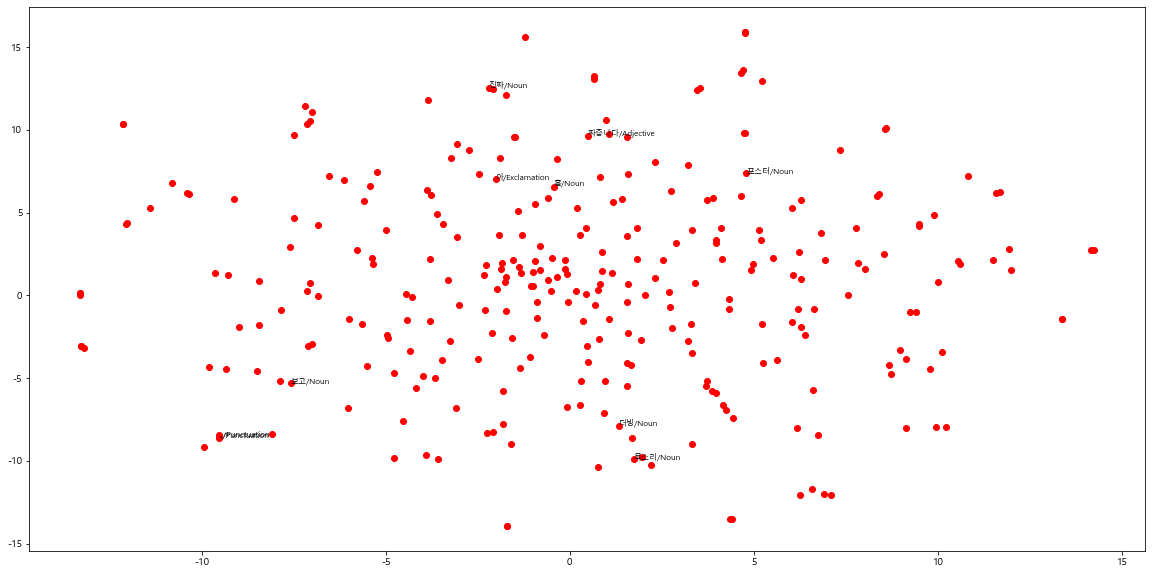

In [54]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
import matplotlib as mpl

mpl.rcParams['axes.unicode_minus'] = False

plt.figure(figsize = (20,10))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c='red')

words = vocab[:10]    
for i, word in enumerate(words):
    plt.text(X_tsne[i,0], X_tsne[i,1 ], word, fontsize=8) 
plt.savefig('out.png', dpi=200)

## 2.6. 특정 단어와 유사한 단어만 출력하기

### text : 1개 입력

In [119]:
tsne = TSNE(n_components =2)


def visualize(text):
    similar_word = w2v_model.wv.most_similar(tokens(text), topn = 30)
    
    data_list = [i[0] for i in similar_word]

    vector_list = [w2v_model[i] for i in data_list]

    X_tsne = tsne.fit_transform(vector_list)
    plt.scatter(X_tsne[:,0], X_tsne[:,1], c='red')

    words = vocab[:10]    
    for i, word in enumerate(words):
        plt.text(X_tsne[i,0], X_tsne[i,1 ], data_list[i], fontsize=8) 
    
    plt.savefig('out.png', dpi=200)

C:\Users\student\.conda\envs\test\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


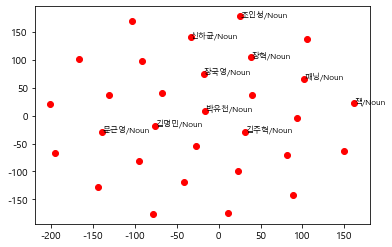

In [121]:
visualize('정우성')

C:\Users\student\.conda\envs\test\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


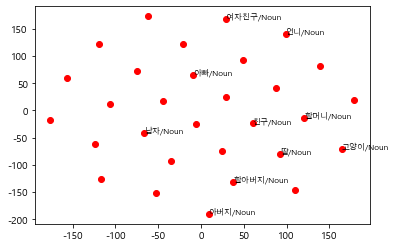

In [122]:
visualize('엄마')

### text : 2개 입력

In [117]:
tsne = TSNE(n_components =2)


def visualize(text, text2):
    similar_word = w2v_model.wv.most_similar(tokens(text), topn = 30)
    similar_word2 = w2v_model.wv.most_similar(tokens(text2), topn = 30)

    
    data_list = [i[0] for i in similar_word]
    data_list2 = [i[0] for i in similar_word2]

    vector_list = w2v_model[data_list]
    vector_list2 = w2v_model[data_list2]
    
    X_tsne = tsne.fit_transform(vector_list)
    X_tsne2 = tsne.fit_transform(vector_list2)

    plt.scatter(X_tsne[:,0], X_tsne[:,1], c='red')
    plt.scatter(X_tsne2[:,0], X_tsne2[:,1], c='blue')


    for i, word in enumerate(zip(data_list, data_list2)):
        plt.text(X_tsne[i,0], X_tsne[i,1 ], data_list[i], fontsize=8) 
        plt.text(X_tsne2[i,0], X_tsne2[i,1 ], data_list2[i], fontsize=8) 

    
    plt.savefig('out.png', dpi=200)

C:\Users\student\.conda\envs\test\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\student\.conda\envs\test\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


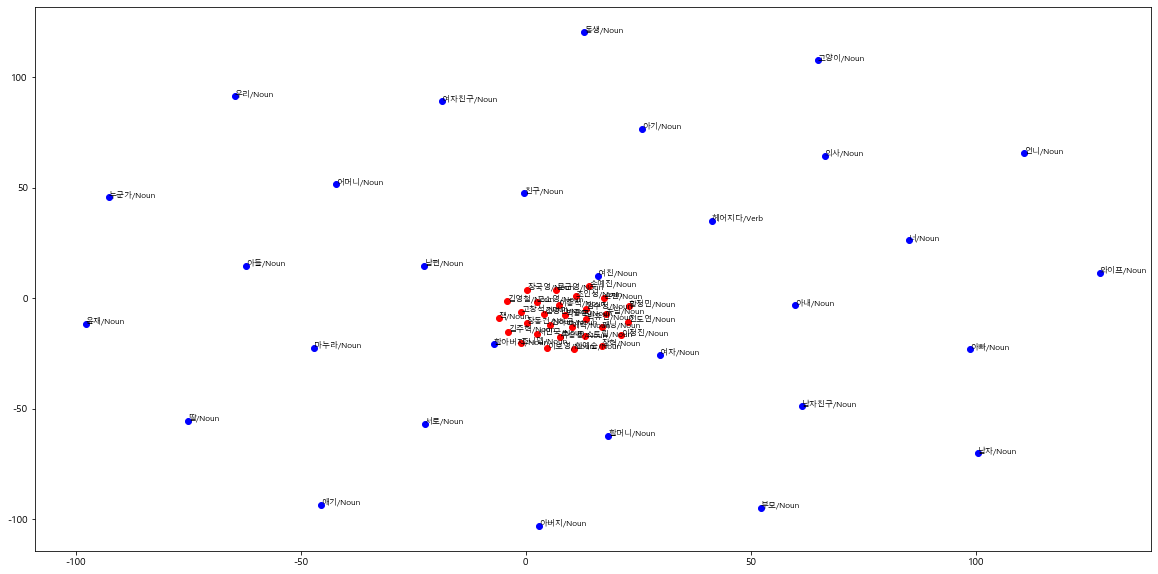

In [114]:
visualize('정우성', '엄마')

### 강사님 코드

In [110]:
group1 = w2v_model.wv.most_similar(tokens('엄마'), topn=30)
group1 = [w for ( w,  s )  in  group1 ]

X1 = w2v_model[group1]


C:\Users\student\.conda\envs\test\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [105]:
group2 = w2v_model.wv.most_similar(tokens('정우성'), topn=30)
group2 = [w for ( w,  s )  in  group2 ]
X2 = w2v_model[group2]

C:\Users\student\.conda\envs\test\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


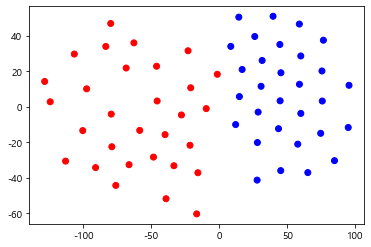

In [106]:
X_tsne =tsne.fit_transform(np.vstack([X1, X2]))

label = np.hstack([0*np.ones(30), np.ones(30)  ])
c = [ 'red'  if l == 0  else 'blue'  for l in label ]

plt.scatter(X_tsne[:,0], X_tsne[:,1], color=c)

### 실행할 때마다 결과가 다름
- 입력 데이터가 같은데..
- 2차원으로 줄이는 과정에서 값이 달라짐

> tsne
- 시각적으로 보이기 위한 용도이므로
- feature로 고정하기 위해서는 pca 알고리즘 사용해야 함.
- clustering 알고리즘으로 누구를 기준으로 잡느냐에 따라 결과가 달라짐. 